# Aim: subset the muscle and re-integrate with scVI

In [43]:
# Import dependencies
%matplotlib inline
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
import yaml
import scvi
import ray
import hyperopt
from ray import tune
from scvi import autotune

# Print date and time:
import datetime
e = datetime.datetime.now()
print ("Current date and time = %s" % e)

# Set other settings
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
scvi.settings.seed = 0

Global seed set to 0


Current date and time = 2024-11-20 11:54:46.272439
-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
aiohttp                     3.9.5
aiohttp_cors                0.7.0
aiosignal                   1.3.1
annotated_types             0.5.0
anyio                       NA
arrow                       1.2.3
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
backoff                     2.2.1
brotli                      NA
bs4                         4.12.2
certifi                     2024.07.04
cffi                        1.15.1
charset_normalizer          3.2.0
chex                        0.1.83
click                       8.1.5
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.1.3
contextlib2                 NA
croniter             

In [44]:
# set a working directory
wdir = '/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles/'
os.chdir( wdir )

# create an output directory with today's date and time
year = e.strftime("%Y")
month = e.strftime("%m")
day = e.strftime("%d")
hour = e.strftime('%H')
minute = e.strftime('%M')
dmyt = f'{year}{month}{day}_{hour}-{minute}'
directory = f'{dmyt}_scVI_on_muscle_subset.dir'

# folder structures
RESULTS_FOLDERNAME = f'{directory}/results/'
FIGURES_FOLDERNAME = f'{directory}/figures/'

if not os.path.exists(RESULTS_FOLDERNAME):
    os.makedirs(RESULTS_FOLDERNAME)
if not os.path.exists(FIGURES_FOLDERNAME):
    os.makedirs(FIGURES_FOLDERNAME)
    
# Set folder for saving figures into
sc.settings.figdir = FIGURES_FOLDERNAME

print(directory)

20241120_11-54_scVI_on_muscle_subset.dir


In [3]:
path = os.path.join(wdir, 'data/integrated_objects/20240926_13-58_convert-objects.dir/Achilles_integrated_annotated.h5ad')
path

'/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles/data/integrated_objects/20240926_13-58_convert-objects.dir/Achilles_integrated_annotated.h5ad'

### Read in adata object
This Achilles data object has been integrated using scVI, then taken back into R and annotated.

In [4]:
adata = sc.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 67668 × 61552
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_soupX', 'nFeature_soupX', 'patient.seqbatch', 'louvain_soupX_snn_res.0.1', 'louvain_soupX_snn_res.0.2', 'louvain_soupX_snn_res.0.3', 'louvain_soupX_snn_res.0.4', 'louvain_soupX_snn_res.0.5', 'louvain_soupX_snn_res.0.6', 'louvain_soupX_snn_res.0.7', 'lo

In [5]:
# scvi works with raw counts
adata.X = adata.layers['counts'].copy()

In [6]:
adata.obs['cell_annotation_scVI_0.2'].unique().astype(str)


array(['Adipocytes', 'NEGR1+ fibroblasts',
       'Fast-twitch skeletal muscle cells', 'Macrophages', 'T cells',
       'ITGA10+ fibroblasts', 'Vascular endothelial cells',
       'Slow-twitch skeletal muscle cells', 'Nervous system cells',
       'Lymphatic endothelial cells', 'Mural cells', 'Granulocytes',
       'B cells', 'Satellite cells', 'B plasma cells',
       'Slow twitch muscle 2'], dtype='<U33')

In [7]:
# subset to skeletal muscle cells
muscle_cells = ['Satellite cells', 'Slow-twitch skeletal muscle cells', 'Fast-twitch skeletal muscle cells']
adata_muscle = adata[adata.obs['cell_annotation_scVI_0.2'].isin(muscle_cells)].copy()
adata_muscle

AnnData object with n_obs × n_vars = 23036 × 61552
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_soupX', 'nFeature_soupX', 'patient.seqbatch', 'louvain_soupX_snn_res.0.1', 'louvain_soupX_snn_res.0.2', 'louvain_soupX_snn_res.0.3', 'louvain_soupX_snn_res.0.4', 'louvain_soupX_snn_res.0.5', 'louvain_soupX_snn_res.0.6', 'louvain_soupX_snn_res.0.7', 'lo

In [8]:
adata_muscle.obs['cell_annotation_scVI_0.2']

MSK0785-Ach-Enth_AAGTTCGCACAAGCCC    Fast-twitch skeletal muscle cells
MSK0785-Ach-Enth_AGGTTGTAGGCGACAT    Slow-twitch skeletal muscle cells
MSK0785-Ach-Enth_ATTACCTAGTGTTGTC    Slow-twitch skeletal muscle cells
MSK0785-Ach-Enth_TCTATCATCGCTACAA    Slow-twitch skeletal muscle cells
MSK0785-Ach-MB_AAGACTCTCTTCGTGC      Fast-twitch skeletal muscle cells
                                                   ...                
MSK1691-ACH-MTJ_TTTGGTTCAGTCAGCC     Fast-twitch skeletal muscle cells
MSK1691-ACH-MTJ_TTTGGTTTCGTTCTAT     Fast-twitch skeletal muscle cells
MSK1691-ACH-MTJ_TTTGTTGAGCATACTC     Fast-twitch skeletal muscle cells
MSK1691-ACH-MTJ_TTTGTTGCAAGGAGTC     Slow-twitch skeletal muscle cells
MSK1691-ACH-MTJ_TTTGTTGGTTCCACGG     Fast-twitch skeletal muscle cells
Name: cell_annotation_scVI_0.2, Length: 23036, dtype: category
Categories (3, object): ['Slow-twitch skeletal muscle cells', 'Fast-twitch skeletal muscle cells', 'Satellite cells']

In [9]:
adata_muscle.obs_names_make_unique()

In [10]:
# calculate 2000 hvg and subset to those genes
sc.pp.highly_variable_genes(adata_muscle, 
                            n_top_genes= 2000, 
                            flavor='seurat_v3', 
                            batch_key='patient.seqbatch',
                            subset = True, 
                           span=0.8) # increase from default of 0.3 to avoid error

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [11]:
adata_muscle

AnnData object with n_obs × n_vars = 23036 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_soupX', 'nFeature_soupX', 'patient.seqbatch', 'louvain_soupX_snn_res.0.1', 'louvain_soupX_snn_res.0.2', 'louvain_soupX_snn_res.0.3', 'louvain_soupX_snn_res.0.4', 'louvain_soupX_snn_res.0.5', 'louvain_soupX_snn_res.0.6', 'louvain_soupX_snn_res.0.7', 'lou

### Optimise the scVI model using ray

In [12]:
# set up the object and view the available paramaters that can be tuned

model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata_muscle, layer="counts", 
                        batch_key='patient.seqbatch')

scvi_tuner = autotune.ModelTuner(model_cls)
scvi_tuner.info()

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


ModelTuner registry for SCVI

                  Tunable hyperparameters                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃      Hyperparameter      ┃ Default value ┃    Source    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│         n_hidden         │      128      │     VAE      │
│         n_latent         │      10       │     VAE      │
│         n_layers         │       1       │     VAE      │
│       dropout_rate       │      0.1      │     VAE      │
│        dispersion        │     gene      │     VAE      │
│     gene_likelihood      │     zinb      │     VAE      │
│   latent_distribution    │    normal     │     VAE      │
│    encode_covariates     │     False     │     VAE      │
│ deeply_inject_covariates │     True      │     VAE      │
│      use_batch_norm      │     both      │     VAE      │
│      use_layer_norm      │     none      │     VAE      │
│        optimizer         │     Adam      │ TrainingPlan │
│            lr            │     0.001     │ TrainingPlan │
│       weight_decay       │     1e-06     │ TrainingPlan │
│           eps            │     0.01      │ TrainingPlan │
│    n_steps_kl_warmup     │     None      │ TrainingPlan │
│    n_epochs_kl_warmup    │      400      │ TrainingPlan │
│   reduce_lr_on_plateau   │     False     │ TrainingPlan │
│        lr_factor         │      0.6      │ TrainingPlan │
│       lr_patience        │      30       │ TrainingPlan │
│       lr_threshold       │      0.0      │ TrainingPlan │
│          lr_min          │       0       │ TrainingPlan │
│      max_kl_weight       │      1.0      │ TrainingPlan │
│      min_kl_weight       │      0.0      │ TrainingPlan │
└──────────────────────────┴───────────────┴──────────────┘

       Available metrics        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃     Metric      ┃    Mode    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ validation_loss │    min     │
└─────────────────┴────────────┘

                         Default search space                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃ Sample function ┃  Arguments  ┃ Keyword arguments ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│    n_hidden    │     choice      │ [[64, 128]] │        {}         │
└────────────────┴─────────────────┴─────────────┴───────────────────┘

In [13]:
# specify which variables will be tested
search_space = {
    "n_latent": tune.choice([10, 30, 50]),
    "n_hidden": tune.choice([60, 128, 256]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])
}

In [14]:
ray.init(log_to_driver=False)

2024-11-18 12:42:42,240	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.16
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [15]:
# run the optimisation

results = scvi_tuner.fit(
    adata_muscle,
    metric="validation_loss",
    search_space=search_space,
    searcher='hyperopt',
    num_samples=100,
    max_epochs=30,
    resources={"gpu": 1}
)

2024-11-18 12:42:50,623	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-11-18 12:51:11,347	WARNING worker.py:2058 -- Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1704, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/ray/util/tracing/tracing_helper.py", line 467

We are looking for the parameters that give the lowest validation loss

In [16]:
print(results.model_kwargs)
print(results.train_kwargs)

{'n_latent': 50, 'n_hidden': 256, 'n_layers': 1, 'gene_likelihood': 'zinb'}
{'plan_kwargs': {'lr': 0.002499855564494562}}


In [17]:
df = results.results.get_dataframe()
df2 = df.sort_values(by = 'validation_loss').reset_index()
df2

,index,validation_loss,timestamp,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/n_latent,config/n_hidden,config/n_layers,config/lr,config/gene_likelihood,logdir
0,73,4.666359e+02,1731934702,False,30,093dfe98,2024-11-18_12-58-22,1.833203,56.128539,940522,...,163.1.64.158,56.128539,30,None,50,256,1,0.002500,zinb,093dfe98
1,58,4.701783e+02,1731934546,False,30,31396c66,2024-11-18_12-55-46,1.794972,53.557693,920424,...,163.1.64.158,53.557693,30,None,50,256,1,0.005747,zinb,31396c66
2,76,4.728401e+02,1731934787,False,30,161ade88,2024-11-18_12-59-47,1.792256,54.497231,920424,...,163.1.64.158,54.497231,30,None,50,256,1,0.002389,zinb,161ade88
3,74,4.743590e+02,1731934733,False,30,6ac352d4,2024-11-18_12-58-53,1.786335,54.133344,920424,...,163.1.64.158,54.133344,30,None,50,256,1,0.004940,zinb,6ac352d4
4,40,4.747307e+02,1731934394,False,30,f8098984,2024-11-18_12-53-14,1.783417,56.733438,920424,...,163.1.64.158,56.733438,30,None,50,256,1,0.003979,zinb,f8098984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,15,1.260837e+03,1731933981,True,1,6d16a0fd,2024-11-18_12-46-21,1.899409,1.899409,876799,...,163.1.64.158,1.899409,1,None,50,60,3,0.000333,nb,6d16a0fd
92,7,1.272786e+03,1731933913,True,1,11fe1aac,2024-11-18_12-45-13,2.182500,2.182500,876259,...,163.1.64.158,2.182500,1,None,10,256,3,0.000119,nb,11fe1aac
93,28,1.287757e+03,1731934208,True,1,8b79353f,2024-11-18_12-50-08,2.106462,2.106462,876799,...,163.1.64.158,2.106462,1,None,50,60,3,0.000156,zinb,8b79353f
94,4,1.209987e+08,1731933894,True,2,e37880b3,2024-11-18_12-44-54,2.144517,4.379555,876259,...,163.1.64.158,4.379555,2,None,50,256,3,0.008563,nb,e37880b3


In [18]:
print("Index of optimal parameters")
row_number = df2['index'][0]
row_number

Index of optimal parameters


73

In [19]:
print("Optimal parameters")
df.iloc[row_number]

Optimal parameters


validation_loss                      466.635895
timestamp                            1731934702
done                                      False
training_iteration                           30
trial_id                               093dfe98
date                        2024-11-18_12-58-22
time_this_iter_s                       1.833203
time_total_s                          56.128539
pid                                      940522
hostname                            BRC-89SJ904
node_ip                            163.1.64.158
time_since_restore                    56.128539
iterations_since_restore                     30
checkpoint_dir_name                        None
config/n_latent                              50
config/n_hidden                             256
config/n_layers                               1
config/lr                                0.0025
config/gene_likelihood                     zinb
logdir                                 093dfe98
Name: 73, dtype: object

In [20]:
ray.shutdown()

### Run scVI using optimised parameters



In [34]:
# set up the adata object
scvi.model.SCVI.setup_anndata(adata_muscle,
                              layer = 'counts',
                              batch_key = "patient.seqbatch"
                             )

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [35]:
# set up the scVI model
# specify the parameters according to the ray optimisation
vae = scvi.model.SCVI(adata_muscle,
                      n_latent = 50,  
                      n_hidden = 256, 
                      n_layers =  1, 
                      dropout_rate = 0.1,
                      dispersion = 'gene-batch',
                     gene_likelihood='zinb')

vae

SCVI Model with the following params: 
n_hidden: 256, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [36]:
# add the parameter for lr
kwargs = {'lr': 0.0025}

In [37]:
 vae.view_anndata_setup(adata_muscle) # check the set up looks as expected

Anndata setup with scvi-tools version 1.0.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'patient.seqbatch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   7   │
│         n_cells          │ 23036 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient.seqbatch'] │ MSK0785_11102021 │          0          │
│                               │ MSK1250_11102021 │          1          │
│                               │ MSK1250_20230822 │          2          │
│                               │ MSK1556_20220808 │          3          │
│                               │ MSK1556_20230822 │          4          │
│                               │ MSK1687_20230822 │          5          │
│                               │ MSK1691_20230822 │          6          │
└───────────────────────────────┴──────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [38]:
# calculate the number of epochs needed which varies according to the cell number
max_epochs_scvi = int(np.min([round((20000 / adata_muscle.n_obs) * 400), 400])) # must be an integer
max_epochs_scvi

347

In [39]:
# run the training (need the GPU queue here)
# updated to 60 epochs due to overfitting
vae.train(max_epochs = 40, 
          train_size = 0.9, 
          validation_size = 0.1, 
          accelerator='gpu', 
          check_val_every_n_epoch=1,
          early_stopping=True,
          early_stopping_patience=10,
          early_stopping_monitor="elbo_validation",
          plan_kwargs = kwargs
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 40/40: 100%|█| 40/40 [01:09<00:00,  1.75s/it, v_num=1, train_loss_step=488

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|█| 40/40 [01:09<00:00,  1.74s/it, v_num=1, train_loss_step=488


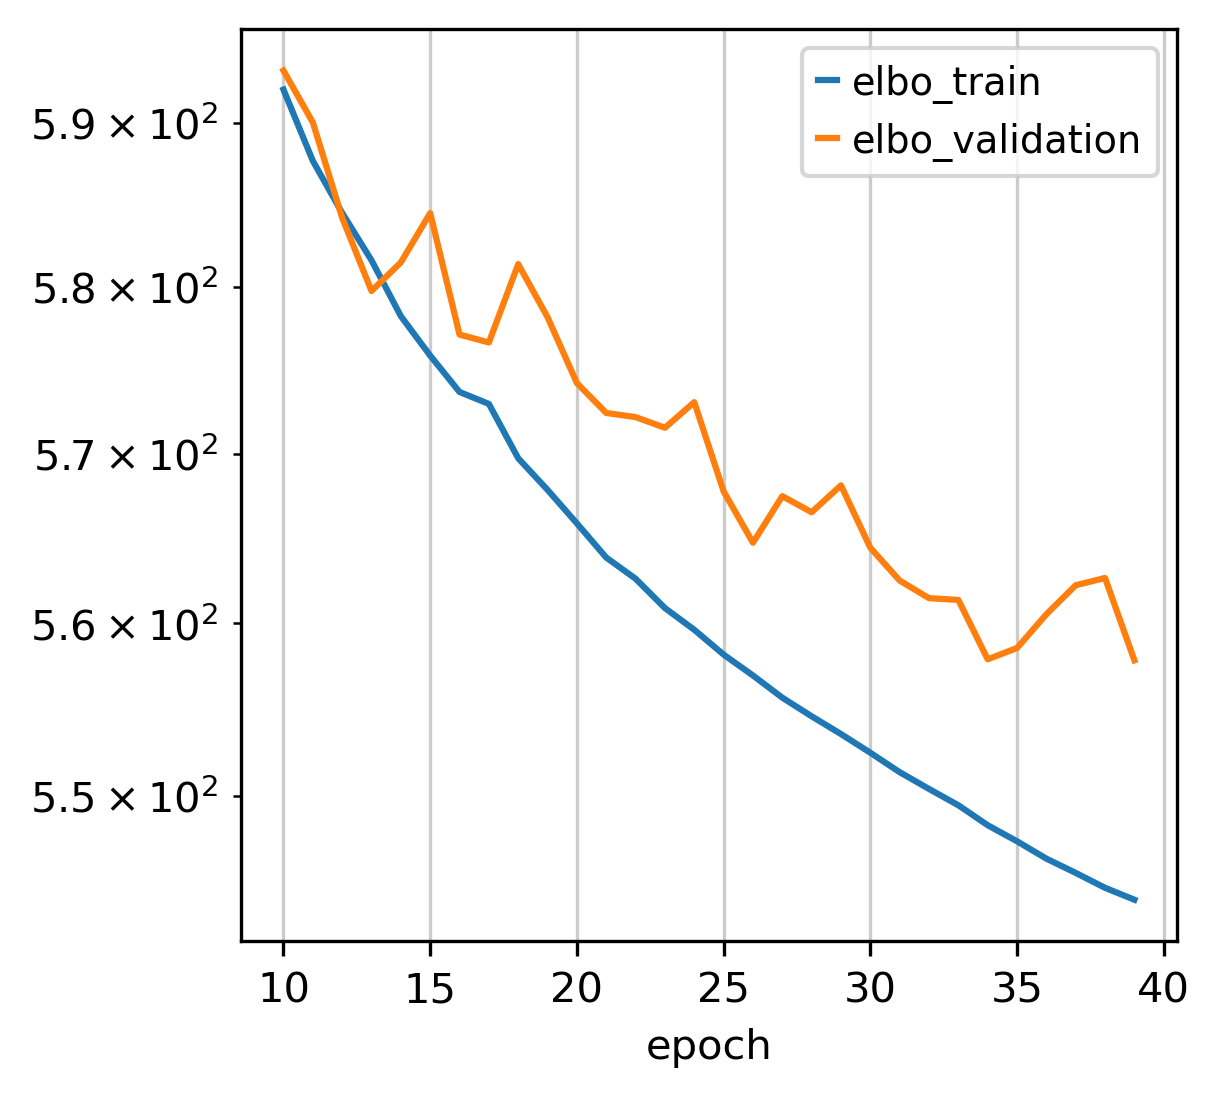

In [40]:
# visualise the results of the training
train_test_results = vae.history["elbo_train"]
train_test_results["elbo_validation"] = vae.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

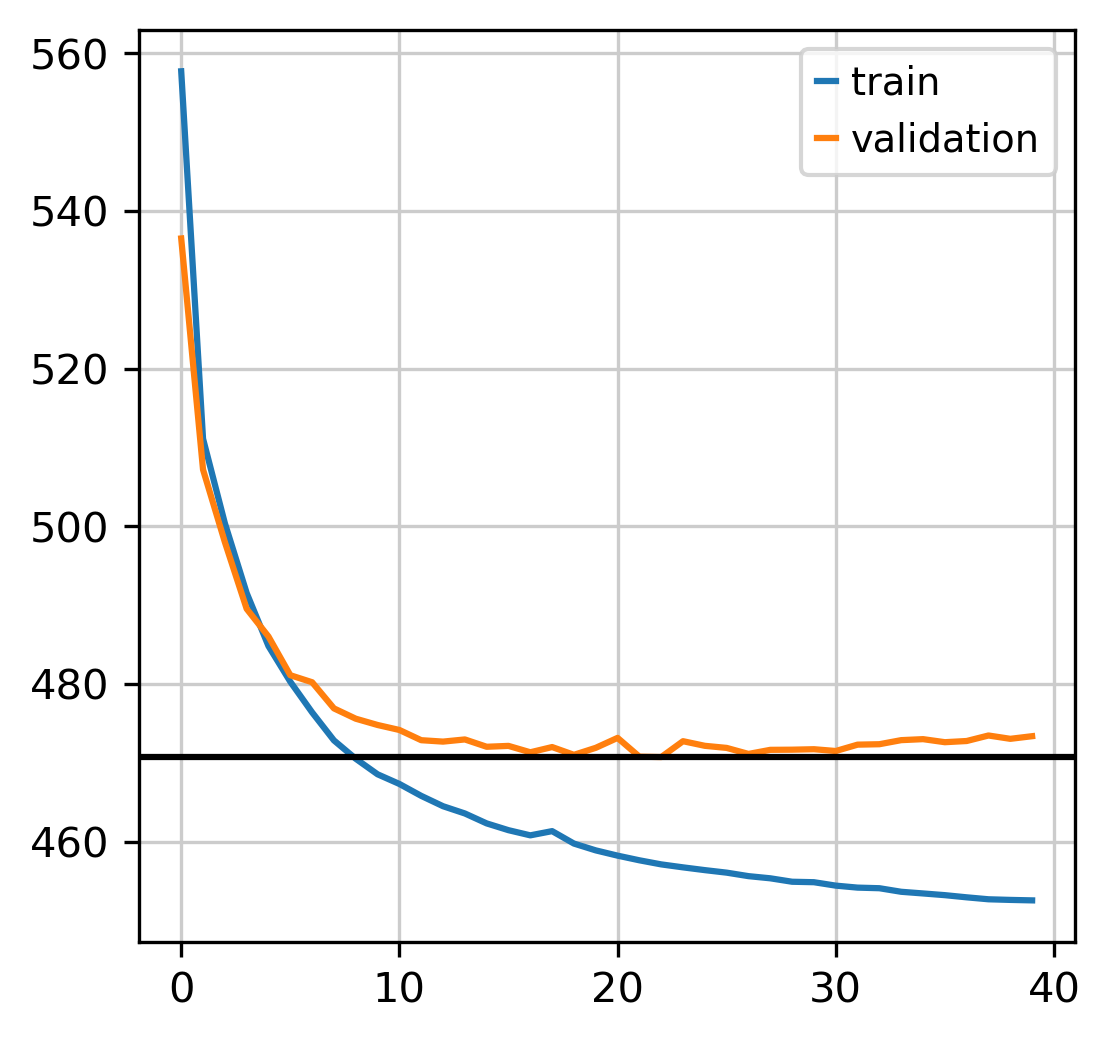

In [41]:
y = vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
plt.axhline(y, c = 'k')
plt.legend()
plt.show()

In [45]:
# save the trained model
# in file name use: sample, covariate, nepochs, n_hidden, n_latent, n_layers, dropout rate, dispersion, gene likelihood
vae.save(os.path.join(RESULTS_FOLDERNAME, "Ach_patient.seqbach_40_256_50_1_01_gene-batch_zinb/"), overwrite=True)

In [46]:
# Extract latent representation embeddings from your trained model 
adata_muscle.obsm["X_scVI"] = vae.get_latent_representation()

In [47]:
# save the object
adata_muscle.write(os.path.join(RESULTS_FOLDERNAME, 'Achilles_scVI.h5ad'))

In [48]:
# Save the scVI embeddings as numpy array
filename = RESULTS_FOLDERNAME + "scVI_embeddings"
np.save(filename, adata_muscle.obsm['X_scVI'])

In [49]:
# Save the metadata
filename = RESULTS_FOLDERNAME + "Achilles_scVI_obs.txt"
adata_muscle.obs.to_csv(filename, sep='\t')